# **Task 4**

The MaxCut problem is a well-known optimization problem in which the nodes of a given
undirected graph have to be divided in two sets (often referred as the set of “white” and “black”
nodes) such that the number of edges connecting a white node with a black node are
maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be
useful

At this [link](https://lucaman99.github.io/new_blog/2020/mar16.html) you can find an explicit implementation of the QAOA algorithm to solve the MaxCut
problem for the simpler case of an unweighted graph. We ask you to generalize the above code
to include also the solution for the case of weighted graphs.




# **Solution**

## **Introduction**

The Maxcut problem is dividing or "cutting" a graph into 2 sets such that edges that connect the nodes between 2 portions have maximum weight. This is done to minimize interaction between the nodes.For analogy, it is assumed that nodes on 1 set will be white and other set will be black. In quantum computing, one way of solving this problem is using QAOA. QAOA (Quantum Approximate Optimization Algorithm) is an algorithm developed for near term quantum devices (NISQ). Quantum devices (at least in near future) are noisy,thus these kinds of algorithms are being developed which gives us a result close to the actual result. QAOA, as the name suggests approximately gives us a good enough result. 


In [13]:
import cirq 
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize
import networkx as nx
from matplotlib import pyplot as plt

Here a graph is plotted with the help of networkx. In this graph, 7 nodes are there and weights are given as inputs in the graph

In [14]:
#plotting the graph

class Graph:
    def __init__(self, edges_set):
        self.edges_set = edges_set
        self.node_set = []
        for i in edges_set:
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)
            if (i.weights not in self.node_set):
                self.node_set.append(i.weights)

class Edge:
    def __init__(self, start_node, end_node,weights):
        self.start_node = start_node
        self.end_node = end_node
        self.weights = weights

set_edges = [Edge(0, 1,1.0), Edge(1, 2,1.5), Edge(2, 3,3.0), Edge(3, 0,2.0), Edge(2, 0,1.0), Edge(1, 3,4.0), Edge(0, 4,1.0), Edge(1, 4,2.5), Edge(2, 4,2.5), Edge(3, 4,1.0), Edge(4, 5,1.0), Edge(5, 0,1.0), Edge(2, 6,3.5), Edge(6, 3,1.0)]

G = nx.Graph()

for z in set_edges:
    G.add_edge(str(z.start_node), str(z.end_node), weight=z.weights)

nx.draw(G)
plt.savefig('graph.png')
plt.clf()

<Figure size 432x288 with 0 Axes>

In [15]:
# Defines the list of qubits

num = 7
depth = 4
rep = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

## **Steps of QAOA**

QAOA like other variational quantum circuits works somewhat like quantum neural networks. 

- First, qubits are initialized
- then they are rotated by some angles (with the help of unitary operators)
- the output bitstring is obtained and cost function is calculated using it classically
- This process is iterated multiple times and minimum value of cost function is obtained and the corresponding bit string is the one closest to the correct answer

here,first, Hadamard gate is applied to all the qubits here for initializing them in uniform superposition 

Then, 2 unitary operators are used consisting of 2 parameters gamma and beta which will be optimized by multiple iterations.The 2 operators are cost unitary and mixer unitary operators: 

### **U(HC,γ)=e^(−iγHC)**
 
### **U(HB,β)=e^(−iβHB)**



In [16]:
# Defines the initialization

def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [17]:
# Defines the cost unitary

def cost_unitary(qubits, gamma):
    for i in set_edges:
        yield cirq.ZZPowGate(exponent=-1*gamma/math.pi).on(qubits[i.start_node], qubits[i.end_node])


In [22]:
# Defines the mixer unitary

def mixer_unitary(qubits, beta):
    i = 1
    for i in range(0, len(qubits)):
        yield cirq.XPowGate(exponent=-1*beta/math.pi).on(qubits[i])

In [23]:
# Executes the circuit

def create_circuit(params):
    
    #parameters alpha and gamma initialized
    gamma = [params[0], params[2], params[4], params[6]] 
    beta = [params[1], params[3], params[5], params[7]]

    circuit = cirq.Circuit()
    
    #qubits are initialized
    circuit.append(initialization(qubits))
    #unitary operators are applied
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, beta[i]))
    #output is measured
    circuit.append(cirq.measure(*qubits, key='x'))
    print(circuit)
    
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=rep)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, rep):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)

    return new_res

## **Cost Function**

Now the classical cost function is defined. It can be defined in many ways, but here the coder has taken cost 
#### **C = $\sum$	0.5*(ca*cb - 1)** ,
where ca represents node in part with node color A of the divided graph and cb represents node in part with node color B. let ca = 1 and cb = -1, then C = 0 if ca = cb and C = -1 if ca != cb. Now, the output bitstring is in the form of 0 and 1, not 1 and -1, so to map 0 : 1 to 1 : -1, the coder here have replaced cn with a function **f(x) = (1 - 2*x)**

#### For weighted graph, here I have just multiplied the weight parameter corresponding to the edge containing the 2 nodes with the cost function
thus new cost function is : 
#### **C = $\sum$	0.5*wab*(ca*cb - 1)**
where wab = weight corresponding to nodes a and b

In [24]:
# Defines the cost function

def cost_function(params):

    av = create_circuit(params)
    total_cost = 0
    for i in range(0, len(av)):
        for j in set_edges:
            total_cost += 0.5*(j.weights)*( ( (1 - 2*av[i][j.start_node]) * (1 - 2*av[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/rep

    print("Cost: "+str(total_cost))

    return total_cost

In [25]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
print(out)

optimal_params = out['x']
f = create_circuit(optimal_params)

                                                       ┌──────────────┐                                  ┌──────────────┐   ┌───────────────┐   ┌────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ────────────────────────────ZZ─────────ZZ────────────────ZZ─────────────────────────────────────────────────────────────────────ZZ──────────────────X^-0.754───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ──────────────────────────────────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.754───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ──────────────────X^0.927───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                          └────────────────┘                                    └────────────────┘   └────────────────┘   └───────────────┘                                                             └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                          └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -10.29
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐  

Cost: -11.002
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.754───ZZ──────────────────────────────────ZZ───────────ZZ──────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.754───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                             └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └──────────────┘
Cost: -13.5115
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌───────────

Cost: -10.023
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌───────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.911───ZZ──────────────────────────────────ZZ───────────ZZ───────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.754───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                          └────────────────┘                                    └────────────────┘   └────────────────┘   └───────────────┘                                                             └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -14.6465
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐  

Cost: -14.807
                                                           ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ───────────────────────────────ZZ──────────ZZ──────────────────ZZ──────────────────────────────────────────────────────────────────────────ZZ──────────────────X^-0.747───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ──────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                                      ┌──────────────────────┐                                             ┌──────────────────────┐   ┌──────────────────────┐   ┌───────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐                                                  ┌────────────┐                               ┌────────────┐   ┌─────────────┐   ┌──────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.739───ZZ────────────────────────────────────────ZZ─────────────ZZ────────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                      └────────────────┘   └──────────────────┘   └────────────────────┘
Cost: -15.316
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                             

Cost: -15.126
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                                      ┌──────────────────────┐                                             ┌──────────────────────┐   ┌──────────────────────┐   ┌───────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌───────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ───────────────────────────────────────

Cost: -15.3325
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                                      ┌──────────────────────┐                                             ┌──────────────────────┐   ┌──────────────────────┐   ┌───────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌──────────────────┐                                                           ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.729───ZZ────────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.739───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

Cost: -14.965
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.685───ZZ──────────────────────────────────ZZ───────────ZZ────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌───────────────┐                                                        ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.662───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.671───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

Cost: -15.3255
                                                           ┌────────────────┐                                      ┌────────────────┐   ┌──────────────────┐   ┌────────────────────┐                                                                ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                             ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ───────────────────────────────ZZ──────────ZZ──────────────────ZZ──────────────────────────────────────────────────────────────────────────────ZZ──────────────────────X^(-11/16)───ZZ──────────────────────────────────ZZ───────────ZZ─────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌───────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.694───ZZ───────────────────────────────ZZ──────────ZZ──────────────────ZZ─────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.705───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                                   ┌────────────────────┐                                          ┌────────────────────┐   ┌────────────────────┐   ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌───────────────┐
(0, 0): ───H───ZZ─────────────────────────────────────ZZ────────────ZZ──────────────────────ZZ────────────────────────────────────────────────────────────────────────────────────────ZZ────────────────────X^-0.698───ZZ──────────────────────────────────ZZ────

Cost: -15.931
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌───────────────┐                                                        ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌───────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.706───ZZ───────────────────────────────ZZ──────────ZZ──────────────────ZZ─────

Cost: -16.07
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                          ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌───────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.725───ZZ──────────────────────────────────ZZ───────────ZZ───────────────────

                                                           ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ───────────────────────────────ZZ──────────ZZ──────────────────ZZ──────────────────────────────────────────────────────────────────────────ZZ──────────────────X^-0.712───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ────────────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                             └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                          └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -15.906
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────

Cost: -15.9695
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.708───ZZ──────────────────────────────────ZZ───────────ZZ───

Cost: -15.9475
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.699───ZZ──────────────────────────────────ZZ───────────ZZ───

Cost: -15.844
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌───────────────┐                                                            ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.702───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ

                                                                   ┌────────────────────┐                                          ┌────────────────────┐   ┌────────────────────┐   ┌──────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ─────────────────────────────────────ZZ────────────ZZ──────────────────────ZZ────────────────────────────────────────────────────────────────────────────────────────ZZ────────────────────X^-0.708───ZZ──────────────────────────────────ZZ───

                                                           └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                     └──────────────┘                                 └──────────────┘   └──────────────┘   └──────────────┘
Cost: -16.122
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                

Cost: -16.009
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.701───ZZ──────────────────────────────────ZZ───────────ZZ────

                                                                   └────────────────────┘                                          └────────────────────┘   └────────────────────┘   └──────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -15.981
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                       

Cost: -16.01
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ─────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.705───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -16.0465
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌─────

Cost: -15.908
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.701───ZZ──────────────────────────────────ZZ───────────ZZ────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -16.0035
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌─────

Cost: -16.1105
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ───

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -15.928
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -16.0235
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌─────

Cost: -16.1105
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ───

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

Cost: -16.0595
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ───

Cost: -15.947
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ────

Cost: -15.9385
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ───

Cost: -16.1825
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ───

Cost: -16.006
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -15.977
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -16.166
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────

Cost: -16.094
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -16.133
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────

                                                               └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └─────────────────┘                                                              └──────────────────┘                                       └──────────────────┘   └──────────────────┘   └────────────────┘                                                         └────────────────┘                                    └────────────────┘   └────────────────┘   └────────────────┘
Cost: -15.8585
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌─────

Cost: -16.0095
                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ───

                                                               ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌─────────────────┐                                                              ┌──────────────────┐                                       ┌──────────────────┐   ┌──────────────────┐   ┌────────────────┐                                                         ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───ZZ──────────────────────────────────ZZ───────────ZZ────────────────────ZZ─────────────────────────────────────────────────────────────────────────────────ZZ───────────────────X^-0.703───ZZ──────────────────────────────────ZZ───────────ZZ──────────────────

[35, 77, 85, 37, 104, 69, 92, 43, 12, 122, 71, 78, 39, 82, 1, 18, 42, 22, 99, 50, 72, 87, 79, 108, 38, 28, 90, 93, 15, 30, 81, 3, 97, 23, 83, 44, 86, 65, 64, 95, 113, 55, 51, 56, 60, 84, 29, 117, 75, 101, 41, 53, 109, 27, 33, 120, 115, 96, 105, 62, 45, 8, 112, 14, 116, 68, 98, 26, 2, 49, 36, 58, 124, 47, 10, 11, 20, 73, 89, 76, 100, 114, 88, 125, 32, 24, 111, 40, 123, 63, 54, 19, 7, 5, 94, 127, 80, 13, 0, 52, 126, 106, 34, 91, 46, 67, 21, 103, 17, 31, 70]
[0.053, 0.047, 0.038, 0.035, 0.018, 0.014, 0.066, 0.009, 0.001, 0.005, 0.014, 0.009, 0.013, 0.003, 0.006, 0.008, 0.043, 0.004, 0.007, 0.04, 0.001, 0.002, 0.002, 0.004, 0.006, 0.011, 0.051, 0.005, 0.017, 0.046, 0.005, 0.013, 0.04, 0.008, 0.014, 0.008, 0.004, 0.006, 0.002, 0.004, 0.003, 0.005, 0.008, 0.009, 0.008, 0.011, 0.007, 0.004, 0.01, 0.008, 0.004, 0.002, 0.003, 0.009, 0.007, 0.003, 0.002, 0.005, 0.004, 0.007, 0.003, 0.001, 0.015, 0.006, 0.002, 0.001, 0.006, 0.01, 0.005, 0.004, 0.001, 0.011, 0.012, 0.002, 0.004, 0.002, 0.003, 0.00

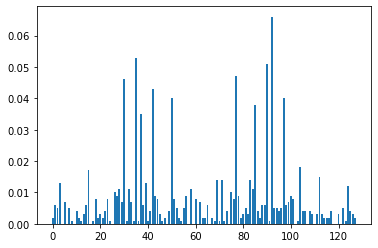

In [12]:
# Creates visualization of the optimal state

nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

print(nums)
print(freq)

x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)

plt.bar(x, y)
plt.show()

## **Result**

Here we can see that the states **|91> = |1011011>** and **|36> = |0100100>** are found to be the optimal state for this case, that is the graph is cut in such a way that nodes will 1 in corresponding index will be color coded "black" and with 0 will be color coded "white" or vice-versa